In [1]:
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
import scipy
import torch

# import enumerate

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet
from src.siamese_net_sound_similarity.soft_dtw import SoftDTW


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

## Load data

In [3]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.02
}

In [4]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [5]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

Text(0.5,1,'negative DTW = 0.0770')

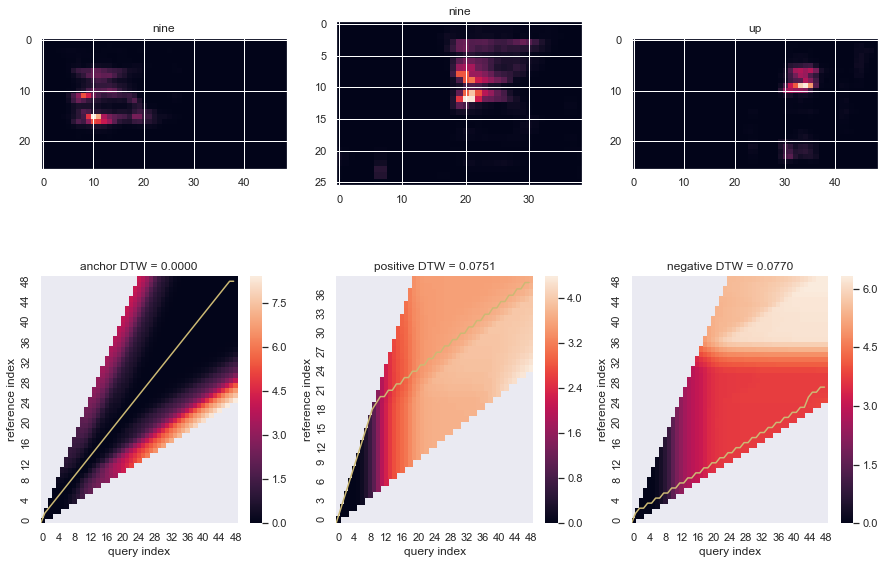

In [6]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(data['x'][i].T)
# fig.colorbar(im)
label = index_to_word[data['y'][0]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[data['y'][0]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][0]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = data['x'][i]

# self dtw (extpected to be 0)

y = data['x'][i]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# Gather Data for analysis

In [20]:
n_mini_batch_size = 1000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


## DTW distribution on raw data

In [21]:

# initialize dist_lists

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    duplicates_dtw.append(dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    non_duplicates_dtw.append(dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)    

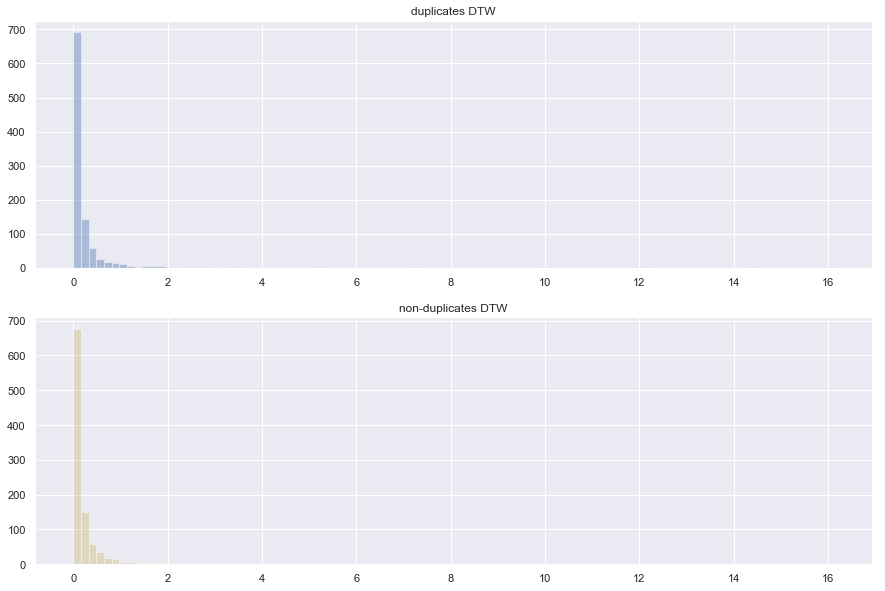

In [22]:
bins = np.linspace(0, min(max(np.max(duplicates_dtw), np.max(non_duplicates_dtw)), 100.), 100)
fig, axes = plt.subplots(2, 1, figsize=(15,10))

duplicates_dtw_filtered = np.array(duplicates_dtw)[np.where(np.array(duplicates_dtw) < 100.)]
non_duplicates_dtw_filtered = np.array(non_duplicates_dtw)[np.where(np.array(non_duplicates_dtw) < 100.)]


sns.distplot(duplicates_dtw,  bins=bins, ax=axes[0], kde=False)
axes[0].title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw, bins=bins,  color='y', ax=axes[1], kde=False)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [23]:
hist_dup, _ = np.histogram(duplicates_dtw)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.0144


### As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between duplicates and non-duplicates pairs. Kullback-Leibler divergence just proves this fact that P (distribution of distances between duplicate samples) and Q (non-duplicate ones) have no significant difference.

# Improving DTW using latent variables from LSTM classifier as a signal

In [24]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_09_26_2019_02_48_PM/net_0.515625.net'

nn = torch.load(nn_fname)

In [25]:
np.arange(20, 50)

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [ ]:
PREFIX_LENS = np.arange(20, 50)

euclidian_distances = np.zeros((len(PREFIX_LENS), n_mini_batch_size*2))

distances = np.zeros((len(PREFIX_LENS), n_mini_batch_size*2))

for k, PREFIX_LEN in enumerate(PREFIX_LENS):
    print(f"    PREFIX LENGTH : {PREFIX_LEN}", end='\r')
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()

    z, *_ = nn.single_forward(nn_input)
    z = z.detach().cpu().numpy()

    duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
    duplicates_z = duplicates_z.detach().cpu().numpy()

    non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
    non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()

        y_duplicate = duplicates_z[i].squeeze()
        d = dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
        distances[k, i] = d.normalized_distance
        euclidian_distances[k, i] = np.linalg.norm(z[i, k] - duplicates_z[i, k])
#         df = df.append([PREFIX_LEN, d, 'positive'])

        y_non_duplicate = non_duplicates_z[i].squeeze()
        d = dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
        distances[k, i + n_mini_batch_size] = d.normalized_distance
        euclidian_distances[k, i + n_mini_batch_size] = np.linalg.norm(z[i, k] - non_duplicates_z[i, k])
#         df = df.append([PREFIX_LEN, d, 'negative'])



   
df = pd.DataFrame({'prefix_len': [e for e in PREFIX_LENS for _ in range(n_mini_batch_size)] * 2,
                   'dist': distances[:, :n_mini_batch_size].flatten().tolist() +  distances[:, n_mini_batch_size:].flatten().tolist(),
                   'class':["positive"]*(n_mini_batch_size*len(PREFIX_LENS)) + ["negative"]*(n_mini_batch_size*len(PREFIX_LENS))})
eu_df = pd.DataFrame({'prefix_len': [e for e in PREFIX_LENS for _ in range(n_mini_batch_size)] * 2,
                   'dist': euclidian_distances[:, :n_mini_batch_size].flatten().tolist() +  euclidian_distances[:, n_mini_batch_size:].flatten().tolist(),
                   'class':["positive"]*(n_mini_batch_size*len(PREFIX_LENS)) + ["negative"]*(n_mini_batch_size*len(PREFIX_LENS))})

# for i  in range(n_mini_batch_size):
fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'DTW (open_end = True)')
sns.lineplot(x='prefix_len', y='dist', data=df, ax=axes, alpha=0.6, hue='class')
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('DTW normalized')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'Euclidean distance between samples in embedding space')
sns.lineplot(x='prefix_len', y='dist', data=eu_df, ax=axes, alpha=0.6, hue='class')
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('Euclidean distance')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()

In [ ]:
soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')

PREFIX_LENS = np.arange(20, 50)

euclidian_distances = np.zeros((len(PREFIX_LENS), n_mini_batch_size*2))

distances = np.zeros((len(PREFIX_LENS), n_mini_batch_size*2))

for k, PREFIX_LEN in enumerate(PREFIX_LENS):
    print(f"    PREFIX LENGTH : {PREFIX_LEN}", end='\r')
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()

    z, *_ = nn.single_forward(nn_input)
    z = z.detach().cpu().numpy()

    duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
    duplicates_z = duplicates_z.detach().cpu().numpy()

    non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
    non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()

        y_duplicate = duplicates_z[i].squeeze()
        d = soft_dtw_loss_open_end(x, y_duplicate)
        distances[k, i] = d.normalized_distance
        euclidian_distances[k, i] = np.linalg.norm(z[i, k] - duplicates_z[i, k])
#         df = df.append([PREFIX_LEN, d, 'positive'])

        y_non_duplicate = non_duplicates_z[i].squeeze()
        d = soft_dtw_loss_open_end(x, y_duplicate)
        distances[k, i + n_mini_batch_size] = d.normalized_distance
        euclidian_distances[k, i + n_mini_batch_size] = np.linalg.norm(z[i, k] - non_duplicates_z[i, k])
#         df = df.append([PREFIX_LEN, d, 'negative'])



   
df = pd.DataFrame({'prefix_len': [e for e in PREFIX_LENS for _ in range(n_mini_batch_size)] * 2,
                   'dist': distances[:, :n_mini_batch_size].flatten().tolist() +  distances[:, n_mini_batch_size:].flatten().tolist(),
                   'class':["positive"]*(n_mini_batch_size*len(PREFIX_LENS)) + ["negative"]*(n_mini_batch_size*len(PREFIX_LENS))})
eu_df = pd.DataFrame({'prefix_len': [e for e in PREFIX_LENS for _ in range(n_mini_batch_size)] * 2,
                   'dist': euclidian_distances[:, :n_mini_batch_size].flatten().tolist() +  euclidian_distances[:, n_mini_batch_size:].flatten().tolist(),
                   'class':["positive"]*(n_mini_batch_size*len(PREFIX_LENS)) + ["negative"]*(n_mini_batch_size*len(PREFIX_LENS))})

# for i  in range(n_mini_batch_size):
fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'DTW (open_end = True)')
sns.lineplot(x='prefix_len', y='dist', data=df, ax=axes, alpha=0.6, hue='class')
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('DTW normalized')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(15,8))
axes.title.set_text(f'Euclidean distance between samples in embedding space')
sns.lineplot(x='prefix_len', y='dist', data=eu_df, ax=axes, alpha=0.6, hue='class')
axes.legend()
plt.xlabel('Query length (number of samples)')
plt.ylabel('Euclidean distance')
# sns.relplot(x= np.arange(20, 50), y=distances[:, i+n_mini_batch_size], color='y', alpha=0.3)
plt.show()